In [1]:
import h5py
import numpy as np
from tqdm import notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.transform import rescale,resize
from skimage import morphology
import math 
import os 
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import pickle
import scipy.io as sio

C:\Users\dawnp\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.chdir('C:/Users/dawnp/Documents/UChicago/PalmerKasthuriLab/NocturnalDiurnal11_2021/') #Set directory for project

In [3]:
f_name = './ConePoints/conePointsygw13cc.mat' #Set file of individual you want to create typical cone for from ConePoints folder
all_mat = sio.loadmat(f_name)

pc_dict = defaultdict(list)

x_pc = all_mat['labels_xvals']
y_pc = all_mat['labels_yvals']
z_pc = all_mat['labels_zvals']

for i in np.arange(1, x_pc.shape[1]+1):
    total = np.transpose([x_pc[0,i-1], y_pc[0,i-1], z_pc[0,i-1]])[0,:,:]
    pc_dict[i] = total

In [4]:
px_to_nm = 600 #Define pixel resolution in nanometers

In [5]:
all_PCAs = defaultdict(list)
all_diams = defaultdict(list)
all_centroids = defaultdict(list)
all_first_PCs = defaultdict(list)
bad_label = []
all_norm_locs = defaultdict(list)
pc_norm_dict = defaultdict(list)
global_pointcloud = defaultdict(list)
sample_width = 5
# pragma omp parallel for
for item in notebook.tqdm(pc_dict.keys()):
    point_cloud = []
    test_coord = pc_dict[item]                               # Gets all the locations for the current label
    norm_coord = test_coord - np.mean(test_coord, axis=0)    # Normalizes all the coordinates so the centroid is at 0,0,0. Key step for this PCA hack
    
    try:
        pc_norm_dict[item] = (norm_coord) 
        sparse_norm_coord = norm_coord[::sample_width,:]     # This samples every sample_width locations. This makes this process IMPERFECT but FASTER. Lower sample_width will be more precise, higher will be faster
        pca = PCA(n_components=3)                            # Don't do less than 3, and there's really no reason to do more than 3        
        pca.fit(sparse_norm_coord)
        
        [uall,vall,wall]=pca.components_
        
        for i in norm_coord:
            i = i - np.dot(uall,i)*uall
            point_cloud.append(i) 
      
    
        flat_rep = []
        
        for i in point_cloud:
            (x,y) = (np.dot(vall,i), np.dot(wall,i))        # Honestly don't remember what this does. Wrote it in a fevered rush inspired by Philz's Tesora blend.
            flat_rep.append((x,y))
            
        flat_rep=np.asarray(flat_rep)
       
        dist_list = np.sort(list(
            map(lambda x: 
            np.linalg.norm((0,0) - x) , flat_rep)))         # Determines distance for all points in flattened cone)

        
        all_PCAs[item].append(pca.components_)
        all_centroids[item].append(np.mean(test_coord, axis=0))
        all_first_PCs[item].append(uall)
        all_norm_locs[item].append(norm_coord[:])
        test_coord = np.asarray(test_coord)
        global_pointcloud[item].append(test_coord)

    except:
#         print("BREAKS ON THIS LABEL: " + str(item))
        bad_label.append(item)


  0%|          | 0/671 [00:00<?, ?it/s]

The argument here is that if we are to simulate light through the cones, the best way to do it is not with one or two selected cones recreated by hand, but a platonic cone created by a sort of mode-like analysis of the other cones. I here take normalized (meaning the centroid is at 0,0,0) point cloud for each sample, rotate them so they are facing the same direction, then heatmap the different points (by heatmap I mean attach to each point a number value saying how often that point shows up in all of the normalized point clouds). This then plots the points that are above a certain occurrence value and saves the pointcloud above that threshold into a 3D HDF5. Also has saving and loading functionality b/c the process of heatmapping all the points can take a while.

In [6]:
full_norm_dict = defaultdict(list)
full_norm_list = []
for i in pc_norm_dict.keys():
   
    all_vecs = np.asarray(all_PCAs[i])
    if np.size(all_vecs) > 1:

        og_pc = np.transpose(np.asarray(pc_norm_dict[i]))
        inv_PCs =np.linalg.inv(np.transpose(all_vecs[0,:,:]))
        new_pc = np.floor(np.matmul(inv_PCs,og_pc))
        full_norm_dict[i]=np.transpose(new_pc)
        np.append(full_norm_list, np.transpose(new_pc))

        
full_norm_list=np.asarray(full_norm_list)

In [7]:
#calculates cone ratio
bottomWidths=[]
topWidths=[]
bottom10s=[]
coneRatios=[]
for ii in full_norm_dict:
    x=full_norm_dict[ii][:,0]
    y=full_norm_dict[ii][:,1]
    z=full_norm_dict[ii][:,2]
    topWidthY=np.max(y)-np.min(y)
    topWidthZ=np.max(z)-np.min(z)
    topWidth=(topWidthY+topWidthZ)/2
    topWidths.append(topWidth)
    try:
        bottom10=np.max(x)-np.floor(0.1*(np.max(x)-np.min(x)))
        loc = (x==bottom10)
        bottomWidthY=np.max(y[loc])-np.min(y[loc])
        bottomWidthZ=np.max(z[loc])-np.min(z[loc])
        bottomWidth=(bottomWidthY+bottomWidthZ)/2
    except:
        bottom10=np.nan
        bottomWidth=np.nan
    bottom10s.append(bottom10)
    bottomWidths.append(bottomWidth)
    coneRatio=bottomWidth/topWidth
    coneRatios.append(coneRatio)

In [ ]:
#saves coneRatios, topWidths, and bottomWidths
crDict={"coneRatios":coneRatios,"topWidths":topWidths, "bottomWidths":bottomWidths}

from scipy.io import savemat
savemat("Measurements/ygw13ccConeRatios.mat",crDict)

Text(0.5, 0, 'x')

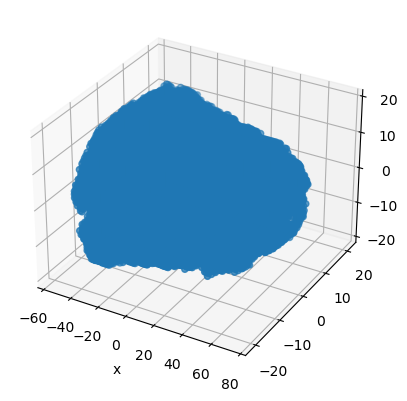

In [9]:
#plots an example cone from the eye
cone_num = 300
x0=full_norm_dict[cone_num][:,0]
y0=full_norm_dict[cone_num][:,1]
z0=full_norm_dict[cone_num][:,2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x0,y0,z0)
ax.set_xlabel("x")

In [10]:
#plots heat map of a typical cone (without a threshold)
x_range = [np.min(new_pc[:,0]), np.max(new_pc[:,0])]
y_range = [np.min(new_pc[:,1]), np.max(new_pc[:,1])]
z_range = [np.min(new_pc[:,2]), np.max(new_pc[:,2])]

loc_heat_map = defaultdict(uint16)
                
for i in notebook.tqdm(full_norm_dict.keys()):
    comp = full_norm_dict[i]
    for loc in comp:
        loc_heat_map[str(loc)]+=1

  0%|          | 0/671 [00:00<?, ?it/s]

(153805,)


  0%|          | 0/153805 [00:00<?, ?it/s]

C:\Users\dawnp\AppData\Local\Temp\ipykernel_21088\1389395852.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = fig.colorbar(colmap)


(63553, 3)


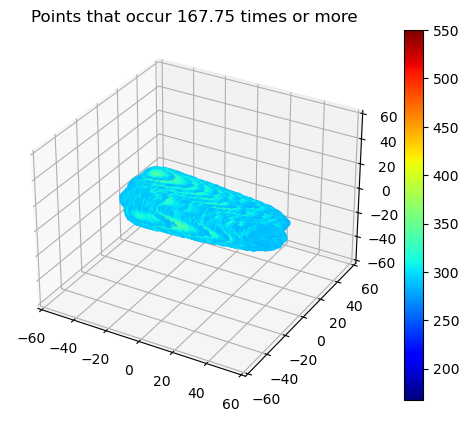

In [11]:
n_loc_heat = loc_heat_map.copy()
plot_locs = []
all_vals = np.asarray(list(n_loc_heat.values()))
print(all_vals.shape)
coloro = 0
limit = len(all_centroids)*.25 #set custom threshold such that any point that is included in at least 25% of all cones is kept

for i in notebook.tqdm(loc_heat_map.keys()):
    if all_vals[coloro]>limit:
        chunks = i[1:-1].strip().split('.')
        try:
            plot_locs.append([int(chunks[0]),int(chunks[1]),int(chunks[2])])
        except:
            plot_locs.append([0,0,0])
    else:
        n_loc_heat.pop(i)
        all_vals[coloro]=0
    coloro+=1

all_vals = np.asarray(list(n_loc_heat.values()))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = cm.jet(all_vals/np.max(all_vals))
colmap = cm.ScalarMappable(cmap=cm.jet)
colmap.set_array(all_vals)
cb = fig.colorbar(colmap)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_zlim(-60,60)
plot_locs=np.asarray(plot_locs)
ax.set_title('Points that occur '+str(limit)+' times or more')
ax.scatter(plot_locs[:,0], plot_locs[:,1], plot_locs[:,2], c=colors)
print(plot_locs.shape)

(63553, 3)


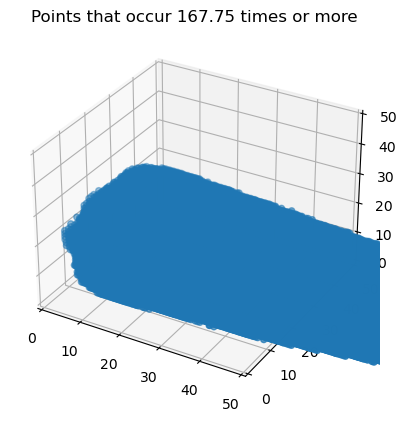

In [12]:
x_min = np.min(plot_locs[:,0])
y_min = np.min(plot_locs[:,1])
z_min = np.min(plot_locs[:,2])

trans_locs = plot_locs

trans_locs[:,0]-=x_min
trans_locs[:,1]-=y_min
trans_locs[:,2]-=z_min

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(0,50)
ax.set_ylim(0,50)
ax.set_zlim(0,50)
ax.set_title('Points that occur '+str(limit)+' times or more')
ax.scatter(trans_locs[:,0], trans_locs[:,1], trans_locs[:,2])
print(plot_locs.shape)

In [13]:
x_max = np.max(trans_locs[:,0])
y_max = np.max(trans_locs[:,1])
z_max = np.max(trans_locs[:,2])

platonic_cone_arr = np.zeros((x_max, y_max, z_max))
print(platonic_cone_arr.shape)
print(np.asarray(np.where(platonic_cone_arr==255)))
# for [locx,locy,locz] in trans_locs[:,:]:
for i in np.arange(trans_locs.shape[0]):
    [locx,locy,locz] = trans_locs[i,:].astype(int)-1
    platonic_cone_arr[locx,locy,locz]=255
print(np.asarray(np.where(platonic_cone_arr==255)).shape)

(92, 36, 35)
[]
(3, 63477)


In [ ]:
cone_f = h5py.File('./PlatonicCones/07CYDpc.h5', 'w')
d = cone_f.create_dataset('cone', data=trans_locs)
cone_f.close()